In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)
import pandas as pd
import numpy as np
# from utils import make_vocab, stoi, training_loop
# from model import CustomResNet
# from dataset import CocoDataset
from tqdm import tqdm, trange
from torchvision.transforms import Compose, Resize, Normalize, CenterCrop
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)
import json
import copy

In [2]:
image_captions_df = pd.read_parquet('F://coco/captions/image_captions_df_less_than_15.parquet')
image_captions_df

,image_id,file_name,captions,caption_token_set,idx_captions,tokens,shortest_token,shortest_token_len
0,57870,COCO_train2014_000000057870.jpg,"[[a, restaurant, has, modern, wooden, tables, ...","[arrangement, is, flower, on, table, blue, top...","[[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...","[[a, restaurant, has, modern, wooden, tables, ...","[a, table, is, adorned, with, wooden, chairs, ...",11
1,384029,COCO_train2014_000000384029.jpg,"[[a, man, preparing, desserts, in, a, kitchen,...","[types, desserts, person, is, kitchen, many, u...","[[27, 53, 56, 33, 29, 27, 35, 42, 29, 50], [27...","[[a, man, preparing, desserts, in, a, kitchen,...","[close, up, of, a, hand, touching, various, pa...",9
2,222016,COCO_train2014_000000222016.jpg,"[[a, big, red, telephone, booth, that, a, man,...","[inside, person, image, standing, is, an, that...","[[27, 66, 62, 67, 65, 61, 27, 53, 1, 59, 29], ...","[[a, big, red, telephone, booth, that, a, man,...","[a, man, using, a, phone, in, a, phone, booth, .]",10
3,520950,COCO_train2014_000000520950.jpg,"[[the, kitchen, is, full, of, spices, on, the,...","[is, on, that, kitchen, all, utilizes, with, i...","[[20, 35, 1, 73, 28, 80, 3, 20, 75], [27, 35, ...","[[the, kitchen, is, full, of, spices, on, the,...","[a, very, small, kitchen, with, a, stove, and,...",12
4,69675,COCO_train2014_000000069675.jpg,"[[a, child, and, woman, are, cooking, in, the,...","[child, woman, person, on, women, an, together...","[[27, 88, 12, 89, 94, 98, 29, 20, 99], [27, 89...","[[a, child, and, woman, are, cooking, in, the,...","[two, women, cooking, on, stove, in, a, kitche...",10
...,...,...,...,...,...,...,...,...
66657,53136,COCO_train2014_000000053136.jpg,"[[vegetable, and, rice, dish, served, in, a, w...","[bed, vegetables, on, white, top, with, pasta,...","[[2753, 12, 2778, 339, 995, 29, 27, 118, 358],...","[[vegetable, and, rice, dish, served, in, a, w...","[a, white, bowl, contains, shredded, cabbage, ...",9
66658,360271,COCO_train2014_000000360271.jpg,"[[women, sitting, at, a, dinner, table, with, ...","[woman, another, dinner., sitting, is, watchin...","[[90, 215, 102, 27, 311, 4, 7, 140, 145, 102, ...","[[women, sitting, at, a, dinner, table, with, ...","[a, bunch, of, women, are, eating, at, a, table]",9
66660,444010,COCO_train2014_000000444010.jpg,"[[a, group, of, friends, sitting, down, at, a,...","[woman, jovial, sitting, table, group, togethe...","[[27, 362, 28, 2829, 215, 144, 102, 27, 4, 330...","[[a, group, of, friends, sitting, down, at, a,...","[a, jovial, older, couple, and, a, young, woma...",14
66661,565004,COCO_train2014_000000565004.jpg,"[[wine, being, poured, into, a, glass, over, a...","[another, is, on, table, wine, with, red, glas...","[[418, 319, 6776, 161, 27, 686, 139, 27, 4], [...","[[wine, being, poured, into, a, glass, over, a...","[a, wine, glass, being, filled, with, red, win...",9


In [3]:
with open('F:/coco/annotations/instances_train2014.json') as file:
    data = file.read()
    data = json.loads(data)

In [4]:
data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [5]:
category_df = pd.DataFrame.from_records(data['categories'])
# category_df[category_df['id']==55]
category_df

,supercategory,id,name
0,person,1,person
1,vehicle,2,bicycle
2,vehicle,3,car
3,vehicle,4,motorcycle
4,vehicle,5,airplane
...,...,...,...
75,indoor,86,vase
76,indoor,87,scissors
77,indoor,88,teddy bear
78,indoor,89,hair drier


In [6]:
enum_super_categories = list(category_df['supercategory'].unique())
enum_super_categories

['person',
 'vehicle',
 'outdoor',
 'animal',
 'accessory',
 'sports',
 'kitchen',
 'food',
 'furniture',
 'electronic',
 'appliance',
 'indoor']

In [7]:
data_df = pd.DataFrame.from_records(data['annotations'])
data_df.head(2)

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[312.29, 562.89, 402.25, 511.49, 400.96, 425....",54652.95560,0,480023,"[116.95, 305.86, 285.3, 266.03]",58,86
1,"[[252.46, 208.17, 267.96, 210.11, 280.14, 213....",421.47275,0,50518,"[245.54, 208.17, 40.14, 19.1]",58,89


In [8]:

data_df['category_name'] = data_df['category_id'].map(category_df.set_index('id')['name'])
data_df['super_category'] = data_df['category_id'].map(category_df.set_index('id')['supercategory'])
data_df['super_category_id'] = data_df['super_category'].apply(lambda x: enum_super_categories.index(x))
data_df.head(2)

,segmentation,area,iscrowd,image_id,bbox,category_id,id,category_name,super_category,super_category_id
0,"[[312.29, 562.89, 402.25, 511.49, 400.96, 425....",54652.95560,0,480023,"[116.95, 305.86, 285.3, 266.03]",58,86,hot dog,food,7
1,"[[252.46, 208.17, 267.96, 210.11, 280.14, 213....",421.47275,0,50518,"[245.54, 208.17, 40.14, 19.1]",58,89,hot dog,food,7


In [9]:
new_data_df = data_df.groupby(['image_id']).agg(list)
new_data_df.head(2)

,segmentation,area,iscrowd,bbox,category_id,id,category_name,super_category,super_category_id
image_id,,,,,,,,,
9,"[[[500.49, 473.53, 599.73, 419.6, 612.67, 375....","[120057.13925, 44434.751099999994, 49577.94434...","[0, 0, 0, 0, 0, 0, 0, 0]","[[1.08, 187.69, 611.59, 285.84], [311.73, 4.31...","[51, 51, 56, 51, 55, 55, 55, 55]","[1038967, 1039564, 1058555, 1534147, 1913551, ...","[bowl, bowl, broccoli, bowl, orange, orange, o...","[kitchen, kitchen, food, kitchen, food, food, ...","[6, 6, 7, 6, 7, 7, 7, 7]"
25,"[[[437.52, 353.33, 437.87, 326.98, 433.65, 306...","[19686.597949999996, 2785.8475500000004]","[0, 0]","[[385.53, 60.03, 214.97, 297.16], [53.01, 356....","[25, 25]","[598548, 599491]","[giraffe, giraffe]","[animal, animal]","[3, 3]"


In [10]:
new_captions_df = pd.merge(left = image_captions_df, right = new_data_df, how='inner', on='image_id')
new_captions_df.head(2)

,image_id,file_name,captions,caption_token_set,idx_captions,tokens,shortest_token,shortest_token_len,segmentation,area,iscrowd,bbox,category_id,id,category_name,super_category,super_category_id
0,57870,COCO_train2014_000000057870.jpg,"[[a, restaurant, has, modern, wooden, tables, ...","[arrangement, is, flower, on, table, blue, top...","[[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...","[[a, restaurant, has, modern, wooden, tables, ...","[a, table, is, adorned, with, wooden, chairs, ...",11,"[[[233.29, 461.42, 235.35, 395.35, 240.52, 378...","[21635.5728, 15217.232600000001, 9265.96560000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[233.29, 270.45, 170.32, 203.36], [1.02, 279....","[62, 67, 62, 62, 62, 62, 62, 62, 62, 86, 62, 6...","[102924, 118582, 290250, 290659, 290682, 29071...","[chair, dining table, chair, chair, chair, cha...","[furniture, furniture, furniture, furniture, f...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 11, 8, 8, 8, 8, 11..."
1,384029,COCO_train2014_000000384029.jpg,"[[a, man, preparing, desserts, in, a, kitchen,...","[types, desserts, person, is, kitchen, many, u...","[[27, 53, 56, 33, 29, 27, 35, 42, 29, 50], [27...","[[a, man, preparing, desserts, in, a, kitchen,...","[close, up, of, a, hand, touching, various, pa...",9,"[[[215.95, 293.07, 182.2, 241.01, 182.2, 209.2...","[87957.80790000001, 11719.74135, 8757.37445, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[4.82, 2.89, 478.17, 302.71], [312.35, 229.44...","[1, 61, 61, 60, 60, 60, 60, 61, 61, 61, 61, 61...","[423921, 1086559, 1577025, 1925582, 1926447, 1...","[person, cake, cake, donut, donut, donut, donu...","[person, food, food, food, food, food, food, f...","[0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]"


In [11]:
row = new_captions_df.iloc[0]
row

image_id                                                          57870
file_name                               COCO_train2014_000000057870.jpg
captions              [[a, restaurant, has, modern, wooden, tables, ...
caption_token_set     [arrangement, is, flower, on, table, blue, top...
idx_captions          [[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...
tokens                [[a, restaurant, has, modern, wooden, tables, ...
shortest_token        [a, table, is, adorned, with, wooden, chairs, ...
shortest_token_len                                                   11
segmentation          [[[233.29, 461.42, 235.35, 395.35, 240.52, 378...
area                  [21635.5728, 15217.232600000001, 9265.96560000...
iscrowd               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
bbox                  [[233.29, 270.45, 170.32, 203.36], [1.02, 279....
category_id           [62, 67, 62, 62, 62, 62, 62, 62, 62, 86, 62, 6...
id                    [102924, 118582, 290250, 290659, 290682, 2

In [12]:
bboxes = row.bbox
category_id = row.super_category_id
bboxes,category_id

([[233.29, 270.45, 170.32, 203.36],
  [1.02, 279.96, 533.09, 200.04],
  [476.76, 261.03, 119.73, 201.71],
  [10.79, 260.03, 114.33, 124.04],
  [367.82, 264.27, 139.15, 215.73],
  [539.33, 290.16, 100.67, 179.05],
  [364.4, 256.57, 52.66, 26.64],
  [152.17, 256.67, 78.41, 29.11],
  [1.08, 373.21, 31.28, 106.79],
  [298.2, 235.17, 83.01, 34.08],
  [285.8, 257.46, 13.97, 16.14],
  [20.54, 376.76, 83.24, 55.13],
  [263.03, 174.37, 154.64, 125.03],
  [560.8, 413.95, 78.29, 65.25],
  [296.78, 277.79, 32.48, 11.99],
  [292.8, 289.31, 21.41, 11.34],
  [90.67, 271.49, 171.84, 208.51]],
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 11, 8, 8, 8, 8, 11, 11, 8])

In [11]:
manual_transforms = Compose([
                            Resize(size = (448,448)),
                            CenterCrop(size=(448,448)),
#                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [12]:
class CocoDataset(Dataset):
    def __init__(self,data_df, is_train=False, is_val=False, is_test = False, val_percent=10, test_percent = 5, transforms = None):
        self.new_data_df = copy.deepcopy(data_df)
        self.transforms = transforms
        
        
        
        if is_val:
            self.data_df = self.new_data_df.sample(frac = float(val_percent/100), axis = 0, ignore_index = True)
        if is_test:
            self.data_df = self.new_data_df.sample(frac = float(test_percent/100), axis = 0, ignore_index = True)
        else:
            self.data_df = self.new_data_df.sample(frac = 1- (float(val_percent/100) + float(test_percent/100)), axis = 0, ignore_index = True)
            
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, ndx):
        folder_path = 'F://coco/train2014/train2014/'
        
        row = self.data_df.iloc[ndx]
        file_name = row['file_name']
        bboxes = torch.tensor(row['bbox'])/448.0
        cat_id = torch.tensor(row['super_category_id'])
        cat_names = row['super_category']
        image_id = row['image_id']

#             captions_array = torch.tensor(row['shortest_idx_tokens'][0][0])

        # Get the image-data from file_name
        image_array = torchvision.io.read_image(folder_path + file_name)
        image_array = (image_array/255.0).to(torch.float32)
        if self.transforms != None:
            image_array = self.transforms(image_array).to(torch.float32)
        
        # After transforming the image we convert the individual bounding boxes, classes and confidence of object to target tensor
        # The format of the out tensor is [object_confidence, bounding_boxes, one-hot class labels]
        y = torch.full((len(bboxes),1), fill_value = 1)
        new = torch.cat((y,bboxes), axis = 1)
        x = F.one_hot(cat_id, num_classes = 12)
        out = torch.cat((new,x ), axis = 1)
        
        return image_array, out, cat_names, image_id
        
    def get_data_image_id(self,image_id=None):
        """ This function returns an image by its id and the corresponding multiple labesl in a present/no_present binary format"""
        

        folder_path = 'F://coco/train2014/train2014/'

        if image_id == None:
            raise ValueError('Must provide IMAGE ID')
        
        else:
            row = self.data_df[self.data_df['image_id']==image_id]
            file_name = row['file_name'].values[0]
            bounding_boxes_list = row['bbox'].values[0]
            category_id_list = row['category_id'].values[0]
            category_names_list = row['category_name'].values[0]

#             captions_array = torch.tensor(row['shortest_idx_tokens'][0][0])

            # Get the image-data from file_name
            image_array = torchvision.io.read_image(folder_path + file_name)
            image_array = (image_array/255.0).to(torch.float32)
            if self.transforms != None:
                image_array = self.transforms(image_array).to(torch.float32)
                
            # After transforming the image now we set up the target tensor that will be outputted
            # After transforming the image now we set up the target tensor that will be outputted
            y = torch.full((len(category_id_list),1), fill_value = 1)
            new = torch.cat((y,bounding_boxes_list), axis = 1)
            x = F.one_hot(category_id_list, num_classes = 12)
            out = torch.cat((new,x), axis = 1)
            return image_array, out, category_names_list
        
            

In [13]:
test_coco = CocoDataset(data_df=new_captions_df,is_test = True, transforms=manual_transforms)
val_coco = CocoDataset(data_df=new_captions_df,is_val = True, transforms=manual_transforms)
train_coco = CocoDataset(data_df=new_captions_df,is_val = True, transforms=manual_transforms)

test_coco_dataloader = DataLoader(dataset=test_coco,shuffle=True, pin_memory=True,num_workers=2,batch_size = 1)
# val_coco_dataloader = DataLoader(dataset=val_coco,shuffle = True, pin_memory=True,num_workers=2,batch_size = 1)
# train_coco_dataloader = DataLoader(dataset = train_coco, shuffle = True, pin_memory=True,num_workers=2,batch_size = 1)

tensor([[1.0000, 0.0241, 0.3182, 0.7763, 0.4636, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0930, 0.4423, 1.1168, 0.5078, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.5732, 0.2342, 0.8297, 0.3967, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


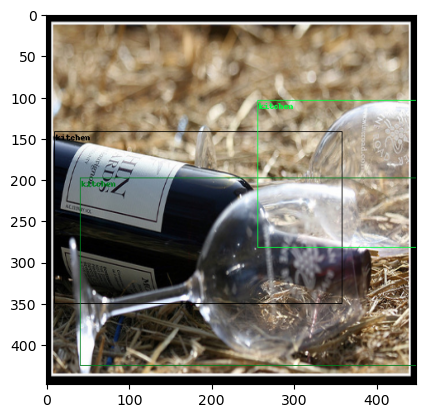

In [21]:
image,out, cat_name, image_id = train_coco[77]
# print(out.shape)
# print(image.shape)
# plt.imshow(image.permute(1,2,0).numpy())
# print(out)
# print(out.shape, len(cat_name), cat_name)
print(out)
box1 = torchvision.ops.box_convert(out[:,1:5], in_fmt='xywh', out_fmt='xyxy')
plot_image = torchvision.utils.draw_bounding_boxes((image*255).to(torch.uint8), box1*448.0, labels=cat_name)
plt.imshow(plot_image.permute(1,2,0).numpy())

In [14]:
class YoloBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(YoloBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=1, bias = False)
        self.batchnorm1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size = 3, padding = 1, bias = False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.batchnorm1(out))

        out = self.conv2(x)
        out = F.relu(self.batchnorm2(out))
        return out

In [15]:
class Yolo(nn.Module):
    def __init__(self):

        super(Yolo,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3,padding=1,bias=False)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1,bias=False)
        self.batchnorm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1,bias=False)
        self.batchnorm4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1,bias=False)
        self.batchnorm5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1,bias=False)
        self.batchnorm6 = nn.BatchNorm2d(512)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv7 = nn.Sequential(YoloBlock(256,512),
                                   YoloBlock(256,512),
                                   YoloBlock(256,512),
                                   YoloBlock(256,512))
        
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1,bias=False)
        self.batchnorm8 = nn.BatchNorm2d(512)
        
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1,bias=False)
        self.batchnorm9 = nn.BatchNorm2d(1024)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv10 = nn.Sequential(YoloBlock(512,1024),
                                    YoloBlock(512,1024),)
        
        self.conv11 = nn.Conv2d(in_channels = 1024, out_channels=1024, kernel_size=3, padding=1,bias=False)
        self.batchnorm11 = nn.BatchNorm2d(1024)
        
        self.conv12 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, stride=2, padding=1,bias=False)
        self.batchnorm12 = nn.BatchNorm2d(1024)
        
        self.conv13 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, padding=1,bias=False)
        self.batchnorm13 = nn.BatchNorm2d(1024)
        
        self.conv14 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, padding=1,bias=False)
        self.batchnorm14 = nn.BatchNorm2d(1024)

        self.linear1 = nn.Linear(in_features=1024, out_features=4096,bias=False)
        self.batchnorm15 = nn.BatchNorm1d(4096)
        
        self.linear2 = nn.Linear(in_features=4096, out_features=34)
    def forward(self, x):
        out = F.relu(self.batchnorm1(self.conv1(x)))
        out = self.maxpool1(out)
        
        out = F.relu(self.batchnorm2(self.conv2(out)))
        out = self.maxpool2(out)
        
        out = F.relu(self.batchnorm3(self.conv3(out)))
        out = F.relu(self.batchnorm4(self.conv4(out)))
        out = F.relu(self.batchnorm5(self.conv5(out)))
        
        out = F.relu(self.batchnorm6(self.conv6(out)))
        out = self.maxpool3(out)
#         print(out.shape)
        out = self.conv7(out)
#         print(out.shape)
        out = F.relu(self.batchnorm8(self.conv8(out)))
        out = F.relu(self.batchnorm9(self.conv9(out)))
        out = self.maxpool4(out)
#         print(out.shape)
        out = self.conv10(out)
    
        out = F.relu(self.batchnorm11(self.conv11(out)))
        out = F.relu(self.batchnorm12(self.conv12(out)))
        out = F.relu(self.batchnorm13(self.conv13(out)))
        out = F.relu(self.batchnorm14(self.conv14(out)))
        print(out.shape)
        out = out.reshape(-1,1024)
        print(out.shape)
        out = F.relu(self.batchnorm15(self.linear1(out)))
        out = self.linear2(out)
        print(out.shape)
        out = out.reshape(7,7,2,-1)
        return out

In [37]:
model = Yolo()
# image = image.unsqueeze(0)
# print(image.shape)
output = model(image.unsqueeze(0))

torch.Size([1, 1024, 7, 7])
torch.Size([49, 1024])
torch.Size([49, 34])


In [38]:
print(output.shape)

torch.Size([7, 7, 2, 17])


Now what we need to do is that we need to make sense of the loss function.

#### Now we will begin to construct the loss function

The loss function here comprises broadly of 3 things:
1. If the object is present in the grid or not --> index[0] of the tensor
2. The bounding box coordinates of the object.(x,y,w,h) --> index[1:4]
3. The class label as a one-hot vector --> index[5:11]

This is for a single object in the tensor. The target tensor consists of multiple tensors, one for each object.

So first we would write the code for the Intersection Over Union.Luckily pytorch has a function to for that which we can use out of the box.

In [16]:
# Now lets code up the loss function
def calculate_loss(pred, targets):
    """This function would calculate the loss for a single image and targets tensor"""
    grid_1, grid_2, bboxes, output = pred.shape
    
    total_loss = 0
    for i in range(grid_1):
        for j in range(grid_2):
            grid_loss = 0
            # For each grid we need to find out the ground truth object with the highest IOU with out predicted bounding boxes
            # Get the two bounding boxes of the predictions
            # pred_bbox_1 = pred[i][j][0:1][:,1:5]
            pred_bbox_1 = pred[i][j][0:1]
            
            # pred_bbox_2 = pred[i][j][1:][:,1:5]
            pred_bbox_2 = pred[i][j][1:]
            
            max_iou = -99 
            
            max_iou_pred_box = None
            max_iou_target_box = None
            # Now we will calulate the iou between each predicted bounding box and each of the bounding boxes of the image.
            for box in targets:
                # Convert the bounding box to the correct format
                box = box.unsqueeze(0)
                converted_bbox = torchvision.ops.box_convert(box[:,1:5], in_fmt='xywh', out_fmt='xyxy')
                
                # Calculate the iou of both of the predicted bounding boxes with  each box to get the highest iou
                pred_bbox_1_iou = torchvision.ops.box_iou(pred_bbox_1[:,1:5], converted_bbox)
                pred_bbox_2_iou = torchvision.ops.box_iou(pred_bbox_2[:,1:5], converted_bbox)

                # Now get the target bbox with the highest_iou with our bboxes.
                if pred_bbox_1_iou > max_iou or pred_bbox_2_iou > max_iou:
                    if pred_bbox_1_iou > pred_bbox_2_iou:
                        max_iou = pred_bbox_1_iou
                        max_iou_pred_box = pred_bbox_1
                        max_iou_target_box = box
                    else:
                        max_iou = pred_bbox_2_iou
                        max_iou_pred_box =  pred_bbox_2
                        max_iou_target_box = box
            
            # Now we have the predicted box with the max iou in max_iou_pred_box and target box with the max iou in max_iou_target_box.
            # Next we will need to calculate the losses of each component of confidence score, box_loss, class_loss
            # First up is the confidence loss
            
            if max_iou > 0.50:
                # This means that the network is confident that there is an object
                confidence_loss = F.mse_loss(max_iou_pred_box[:,0:1]*max_iou, max_iou_target_box[:,0:1])
            else:
                confidence_loss = 0.5 * F.mse_loss(max_iou_pred_box[:,0:1]*max_iou, max_iou_target_box[:,0:1])
            
            # Now the box loss
            bbox_loss = 5* F.mse_loss(max_iou_pred_box[:,1:5], max_iou_target_box[:,1:5])

            # Then we need to calculate the class_loss
            class_loss = F.mse_loss(max_iou_pred_box[:,5:], max_iou_target_box[:,5:])

            # calculate the loss of each individual grid and normalize it with the number of grids
            grid_loss = (grid_loss + confidence_loss + bbox_loss + class_loss)/7.0


        total_loss += grid_loss
    return total_loss



            


##### Now lets write the training loop for this Network
This would take a train dataloader and try to minimize the loss function for one image at a time

In [17]:
def training_loop(epochs, model, train_dataloader, optimizer, ):
    for epoch in range(epochs):

        for batch in train_dataloader:
            print(batch)
            image, targets, cat_name, image_id = batch

            pred = model(image)
            print(pred)

            optimizer.zero_grad()

            loss = calculate_loss(pred, targets)

            print(f"Epoch : {epoch} | Loss : {loss} ")

            loss.backward()

            optimizer.step()

In [18]:
yolo_model = Yolo()
yolo_model = yolo_model.to(device = torch.device('cuda'))
yolo_model

Yolo(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batchno

In [19]:
adam_optimizer = optim.Adam(yolo_model.parameters(), lr = 3e-3)

In [20]:
training_loop(1, yolo_model, test_coco_dataloader, adam_optimizer)